In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

In [2]:
from pyldl.utils import encode_one_hot, kullback_leibler_divergence, load_usps, contingency_matrix
from pyldl.encapsulations import AutoEncoder, Sequential
from pyldl.modules import Linear
from pyldl.losses import BCELoss, MSELoss, CrossEntropyLoss
from pyldl.activations import Sigmoid, Tanh, Softmax
from pyldl.optimizers import SGD

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np

In [3]:
np.random.seed(0)

In [4]:
def add_noise(data, sigma=0.05):
    return data + sigma*np.random.randn(*data.shape) 

## Loading the Dataset

In [5]:
digits = load_digits()

X = digits.data

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_noise = add_noise(X, sigma=0.3)

X_train, X_test, y_train, y_test = train_test_split(X_noise, X, test_size=0.2)

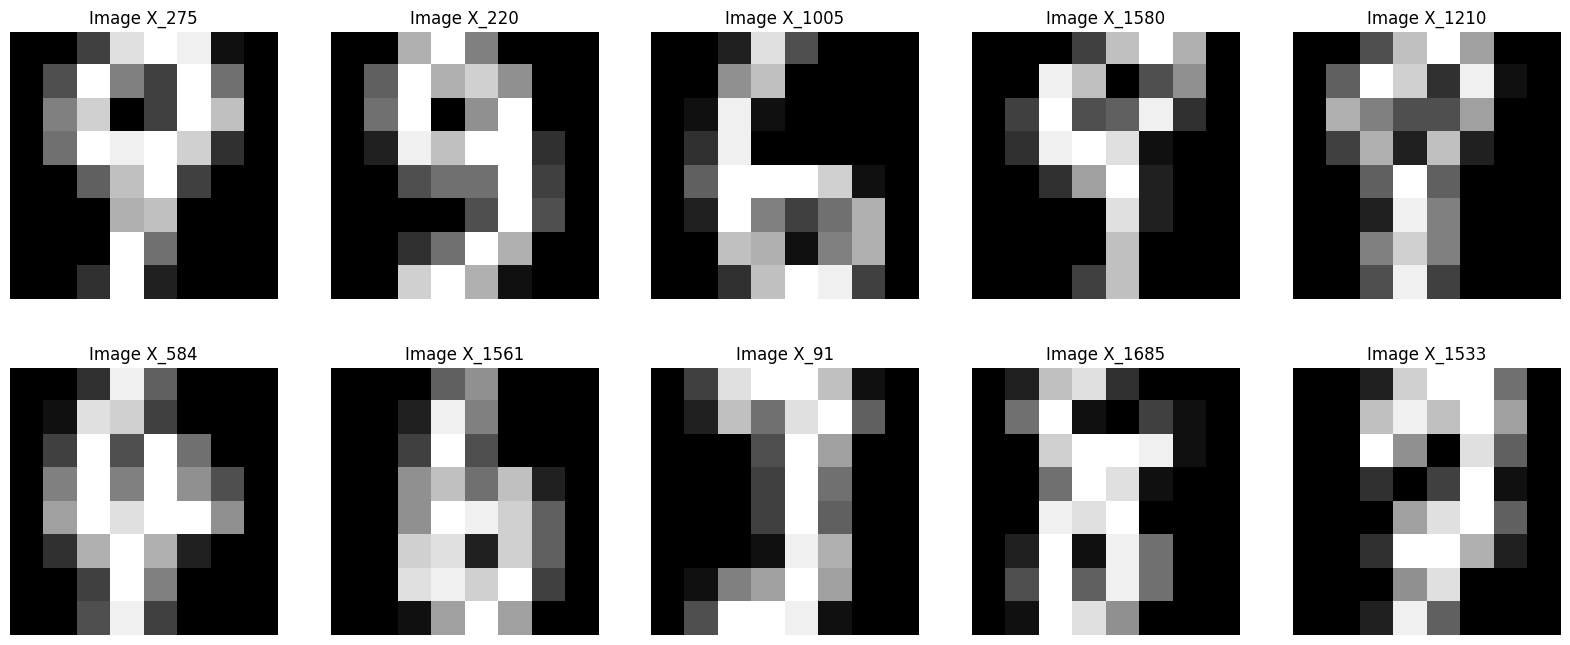

In [6]:
n_images = 10
random_indexes = np.random.choice(range(len(X)), n_images)
images = X[random_indexes]

plt.subplots(2, 5, figsize=(20, 8))
for i in range(n_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Image X_{random_indexes[i]}")
    plt.axis('off')
plt.show()

## Autoencoder and Reconstruction

In [7]:
encoder = Sequential(
    Linear(X_train.shape[1], 32), 
    Tanh(),
    Linear(32, 16),
    Tanh(),
    Linear(16, 2),
    Tanh(),
)

decoder = Sequential(
    Linear(2, 16),
    Tanh(),
    Linear(16, 32),
    Tanh(),
    Linear(32, X_train.shape[1]),
    Sigmoid()
)

autoencoder = AutoEncoder(encoder, decoder)

In [8]:
losses = SGD(autoencoder, MSELoss(), X_train, y_train, batch_size=32, gradient_step=1e-3, n_iter=1000)

100%|██████████| 1000/1000 [00:15<00:00, 62.90it/s]


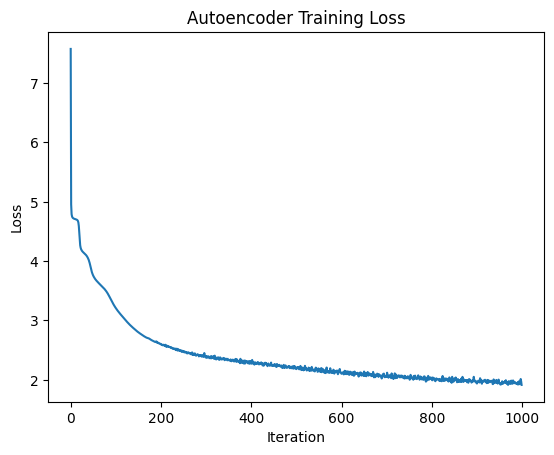

In [9]:
plt.plot(losses)
plt.title("Autoencoder Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The training loss seems to converge at last even though it is slightly unstable and well over 0.

In [10]:
yhat = autoencoder(X_test)
print("Score: ", kullback_leibler_divergence(yhat, y_test))

Score:  41.65803901395548


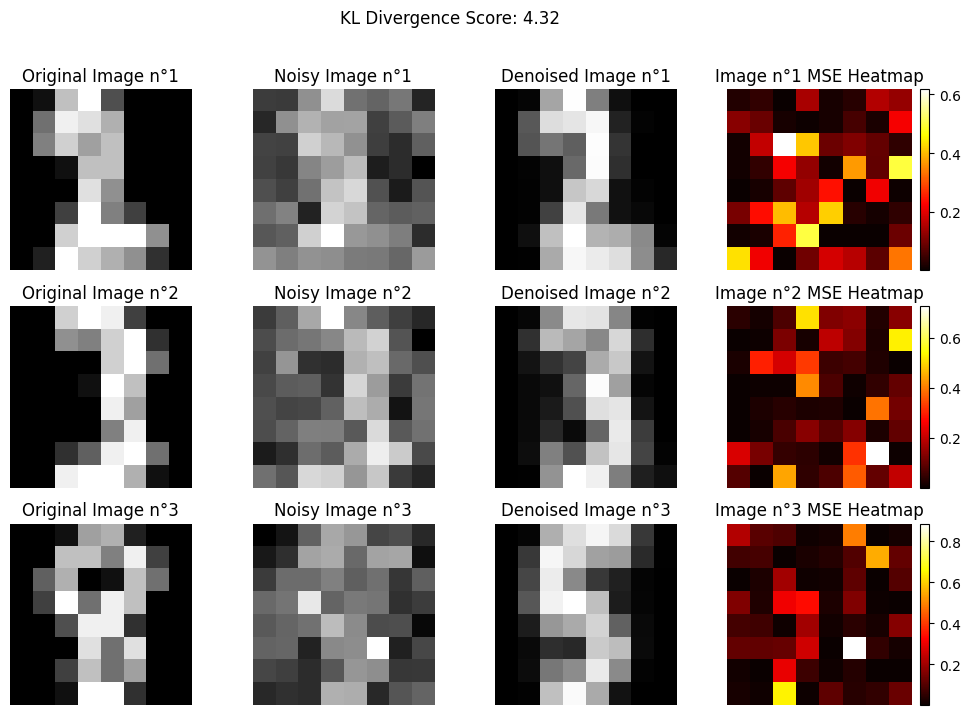

In [11]:
n_images = 3

random_indexes = np.random.choice(range(len(X_test)), n_images)
original_images = y_test[random_indexes]
noisy_images = X_test[random_indexes]
denoised_images = autoencoder(noisy_images)

plt.subplots(3, 4, figsize=(12, 8))
plt.suptitle(f"KL Divergence Score: {kullback_leibler_divergence(original_images, denoised_images):.2f}")

for i in range(n_images):
    plt.subplot(3, 4, 4*i+1)
    plt.imshow(original_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Original Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 4, 4*i+2)
    plt.imshow(noisy_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Noisy Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 4, 4*i+3)
    plt.imshow(denoised_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Denoised Image n°{i+1}")
    plt.axis('off')

    # Calculate and plot the heatmap
    mse_images = (noisy_images[i] - denoised_images[i])**2
    heatmap_data = mse_images.reshape(8, 8)
    plt.subplot(3, 4, 4*i+4)
    heatmap = plt.imshow(heatmap_data, cmap='hot', aspect='auto')
    plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    plt.title(f'Image n°{i+1} MSE Heatmap')
    plt.axis('off')
    
plt.show()

Even though the denoised images differ from the original images, they are not that far from reality, and most of the noise has been erased. The heatmaps however show that pixelwise, there are many differences. It could partly be due to the MSE loss smoothing the intensities.

## Accuracy using noised and denoised images

In [12]:
digits = load_digits()

X = digits.data

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train_one_hot = encode_one_hot(y_train)
y_test_one_hot = encode_one_hot(y_test)

In [13]:
network = Sequential(Linear(X_train.shape[1], 128), Sigmoid(), Linear(128, 64), Sigmoid(), Linear(64, y_train_one_hot.shape[1]))
loss = CrossEntropyLoss()

In [14]:
losses = SGD(network, loss, X_train, y_train_one_hot, batch_size=64, gradient_step=1e-3, n_iter=1000)

100%|██████████| 1000/1000 [00:15<00:00, 66.62it/s]


In [15]:
def predict(X):
    return network(X).argmax(axis=1)

def accuracy(y, yhat):
    return (y == yhat).mean()

yhat = predict(X_test)
print(f"Accuracy: {accuracy(y_test, yhat)*100:.2f}%")

yhat_noise = predict(X_noise)
print(f"Accuracy using noised images: {accuracy(y, yhat_noise)*100:.2f}%")

yhat_denoise = predict(autoencoder(X_noise))
print(f"Accuracy using denoised images: {accuracy(y, yhat_denoise)*100:.2f}%")


Accuracy: 97.22%
Accuracy using noised images: 78.19%
Accuracy using denoised images: 82.25%


While the accuracy using the original images is similar to the one we got with our standard multiclassification network, the accuracies with the noisy and denoised images are much lower. We can still notice that using the denoised images yields slightly better results.

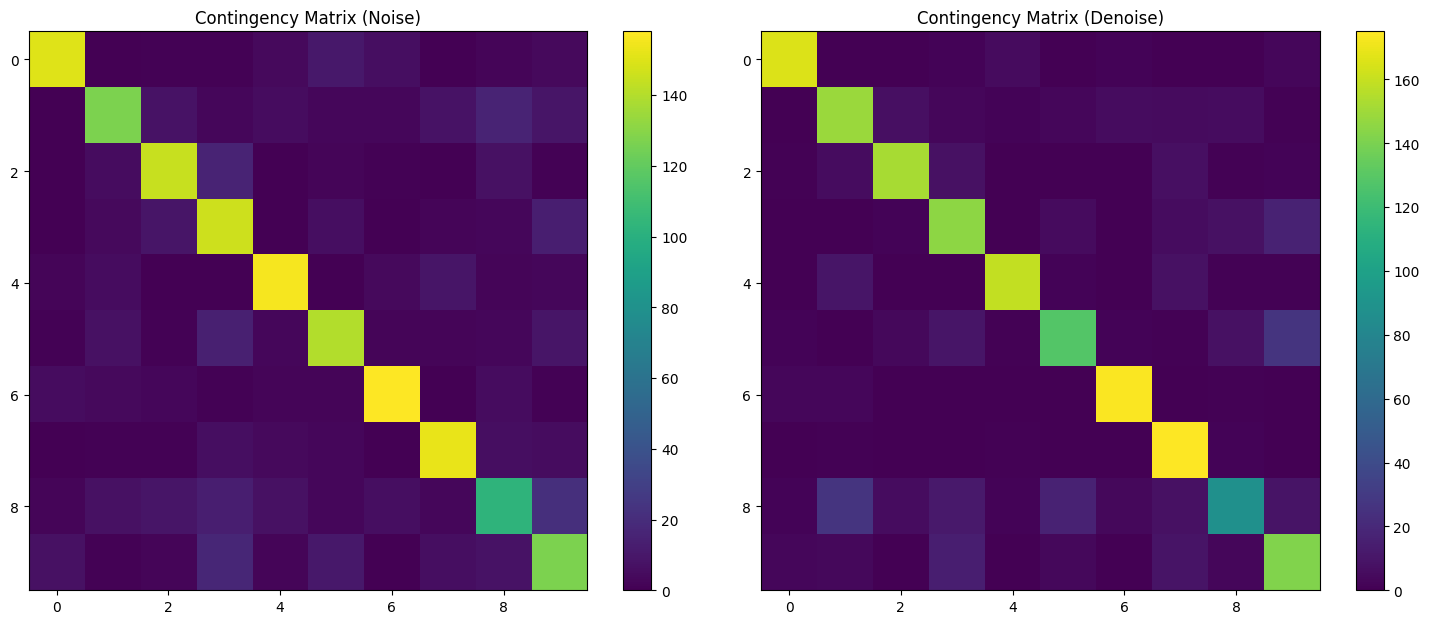

In [16]:
# Calculate contingency matrices
m_noise = contingency_matrix(y, yhat_noise)
m_denoise = contingency_matrix(y, yhat_denoise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting contingency matrix for yhat_noise
axs[0].imshow(m_noise)
axs[0].set_title("Contingency Matrix (Noise)")
plt.colorbar(axs[0].imshow(m_noise), ax=axs[0])

# Plotting contingency matrix for yhat_denoise
axs[1].imshow(m_denoise)
axs[1].set_title("Contingency Matrix (Denoise)")
plt.colorbar(axs[1].imshow(m_denoise), ax=axs[1])

plt.tight_layout()
plt.show()


The contingency matrixes are very similar with the noisy and denoised images. However, with the noisy images, it seems that for a given digit, the range of digits mistaken by the network is wider than with the denoised images.

## Network Optimization

In [17]:
from itertools import product

def grid_search(X_train, X_test, y_train, y_test, params):
    best_score = np.inf
    best_model = None
    best_params = None
    best_losses = None
    for activation, batch_size, gradient_step, loss, n_epochs, n_neurons_per_layer in product(*params.values()):
        encoder_layers, decoder_layers = [], []
        for i in range(len(n_neurons_per_layer)-1):
            encoder_layers += [Linear(n_neurons_per_layer[i], n_neurons_per_layer[i+1]), activation()]
            decoder_layers = [Linear(n_neurons_per_layer[i+1], n_neurons_per_layer[i]), activation()] + decoder_layers
        autoencoder = AutoEncoder(Sequential(*encoder_layers), Sequential(*decoder_layers))
        losses = SGD(autoencoder, loss(), X_train, y_train, batch_size=batch_size, gradient_step=gradient_step, n_iter=n_epochs)
        # reconstructed_images = autoencoder(X_test)
        score = losses[-1]
        if score < best_score:
            best_model = autoencoder
            best_score = score
            best_losses = losses
            best_params = {
                "activation_functions": activation.__name__,
                "batch_size": batch_size,
                "gradient_step": gradient_step,
                "loss": loss.__name__,
                "n_epochs": n_epochs,
                "n_neurons_per_layer": n_neurons_per_layer,
            }
    return best_model, best_params, best_score, best_losses

In [18]:
digits = load_digits()

X = digits.data

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_noise = add_noise(X, sigma=0.3)

X_train, X_test, y_train, y_test = train_test_split(X_noise, X, test_size=0.2)

In [19]:
params = {
    "activation_functions": [Sigmoid, Tanh],
    "batch_size": [32, 64, 128],
    "gradient_step": [0.01, 0.001, 0.0001],
    "loss": [BCELoss, MSELoss],
    "n_epochs": [100, 250, 500],
    "n_neurons_per_layer": [[X_train.shape[1], 32], [X_train.shape[1], 32, 16], [X_train.shape[1], 32, 16, 8]]
}

# params = {
#     "activation_functions": [Tanh],
#     "batch_size": [32],
#     "gradient_step": [0.001],
#     "loss": [MSELoss],
#     "n_epochs": [1000],
#     "n_neurons_per_layer": [[X_train.shape[1], 32, 16, 2]],
# }

best_model, best_params, best_score, best_losses = grid_search(X_train, X_test, y_train, y_test, params)

100%|██████████| 500/500 [00:04<00:00, 105.26it/s]


In [20]:
print("Best parameters: ", best_params)

Best parameters:  {'activation_functions': 'Sigmoid', 'batch_size': 32, 'gradient_step': 0.01, 'loss': 'BCELoss', 'n_epochs': 500, 'n_neurons_per_layer': [64, 32]}


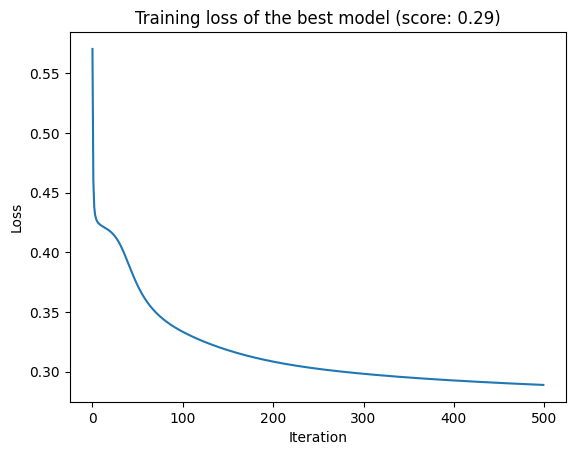

In [21]:
plt.plot(best_losses)
plt.title(f"Training loss of the best model (score: {best_score:.2f})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The training loss has an odd shape at the beginning but it still seems to converge towards close-to-0 values.

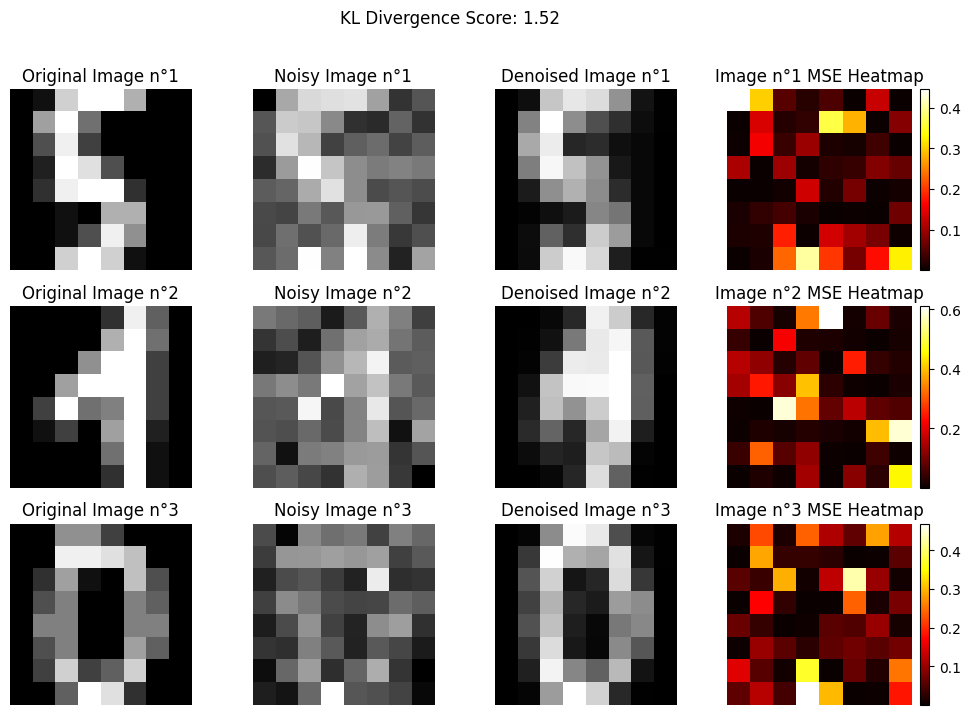

In [22]:
n_images = 3

random_indexes = np.random.choice(range(len(X_test)), n_images)
original_images = y_test[random_indexes]
noisy_images = X_test[random_indexes]
denoised_images = best_model(noisy_images)


plt.subplots(3, 4, figsize=(12, 8))
plt.suptitle(f"KL Divergence Score: {kullback_leibler_divergence(original_images, denoised_images):.2f}")

for i in range(n_images):
    plt.subplot(3, 4, 4*i+1)
    plt.imshow(original_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Original Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 4, 4*i+2)
    plt.imshow(noisy_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Noisy Image n°{i+1}")
    plt.axis('off')

    plt.subplot(3, 4, 4*i+3)
    plt.imshow(denoised_images[i].reshape(8, 8), cmap='gray')
    plt.title(f"Denoised Image n°{i+1}")
    plt.axis('off')

    # Calculate and plot the heatmap
    mse_images = (noisy_images[i] - denoised_images[i])**2
    heatmap_data = mse_images.reshape(8, 8)
    plt.subplot(3, 4, 4*i+4)
    heatmap = plt.imshow(heatmap_data, cmap='hot', aspect='auto')
    plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    plt.title(f'Image n°{i+1} MSE Heatmap')
    plt.axis('off')

Compared to the model we had initially, the reconstructed images are much better. The autoencoder seems to do a great work as it is difficult to recognize the noisy images even for us.

## Accuracy using noised and denoised images

In [23]:
digits = load_digits()

X = digits.data

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train_one_hot = encode_one_hot(y_train)
y_test_one_hot = encode_one_hot(y_test)

network = Sequential(Linear(X_train.shape[1], 128), Sigmoid(), Linear(128, 64), Sigmoid(), Linear(64, y_train_one_hot.shape[1]))
loss = CrossEntropyLoss()

losses = SGD(network, loss, X_train, y_train_one_hot, batch_size=64, gradient_step=1e-3, n_iter=1000)

yhat = predict(X_test)
print(f"Accuracy: {accuracy(y_test, yhat)*100:.2f}%")

yhat_noise = predict(X_noise)
print(f"Accuracy using noised images: {accuracy(y, yhat_noise)*100:.2f}%")

yhat_denoise = predict(best_model(X_noise))
print(f"Accuracy using denoised images: {accuracy(y, yhat_denoise)*100:.2f}%")


100%|██████████| 1000/1000 [00:14<00:00, 67.27it/s]

Accuracy: 95.83%
Accuracy using noised images: 80.08%
Accuracy using denoised images: 85.09%


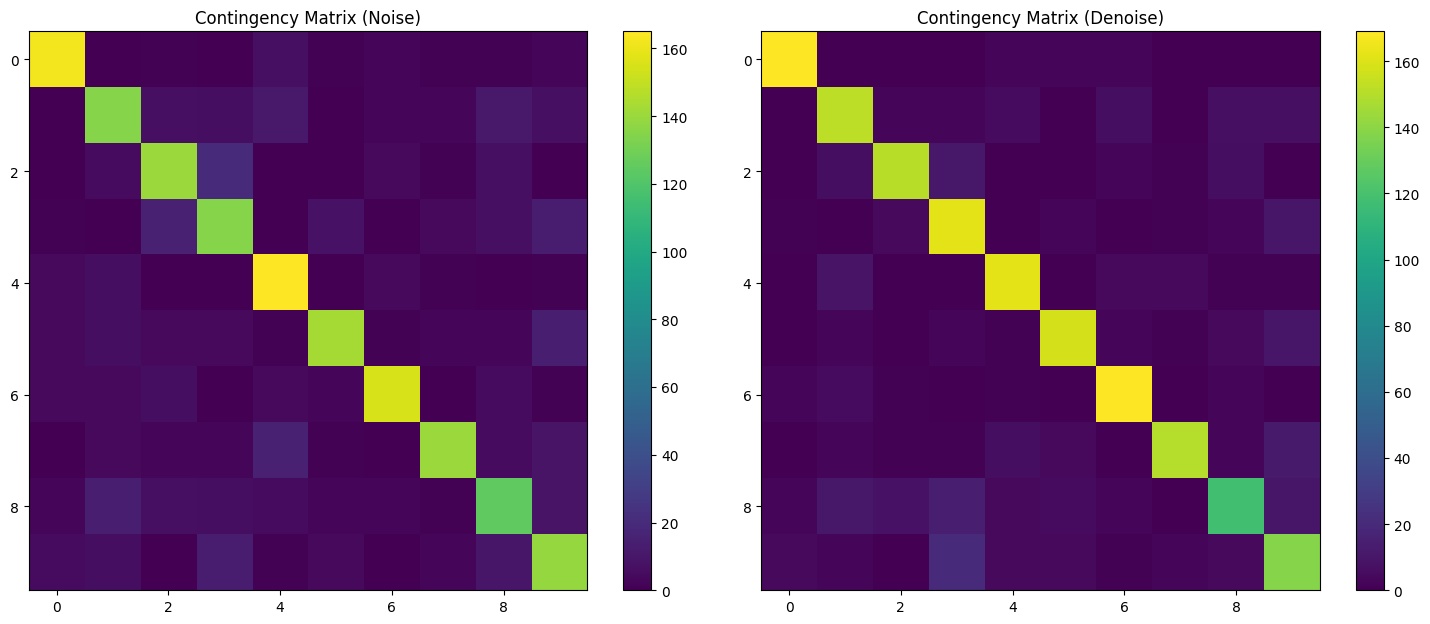

In [24]:
# Calculate contingency matrices
m_noise = contingency_matrix(y, yhat_noise)
m_denoise = contingency_matrix(y, yhat_denoise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting contingency matrix for yhat_noise
axs[0].imshow(m_noise)
axs[0].set_title("Contingency Matrix (Noise)")
plt.colorbar(axs[0].imshow(m_noise), ax=axs[0])

# Plotting contingency matrix for yhat_denoise
axs[1].imshow(m_denoise)
axs[1].set_title("Contingency Matrix (Denoise)")
plt.colorbar(axs[1].imshow(m_denoise), ax=axs[1])

plt.tight_layout()
plt.show()

The contingency matrixes are very similar with the noisy and denoised images. However, with the noisy images, it seems that for a given digit, the range of digits mistaken by the network is wider than with the denoised images.

## Testing on another Dataset

In [25]:
X, _ = load_usps("../data/USPS_data.txt")

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_noise = add_noise(X, sigma=0.3)

X_train, X_test, y_train, y_test = train_test_split(X_noise, X, test_size=0.2)

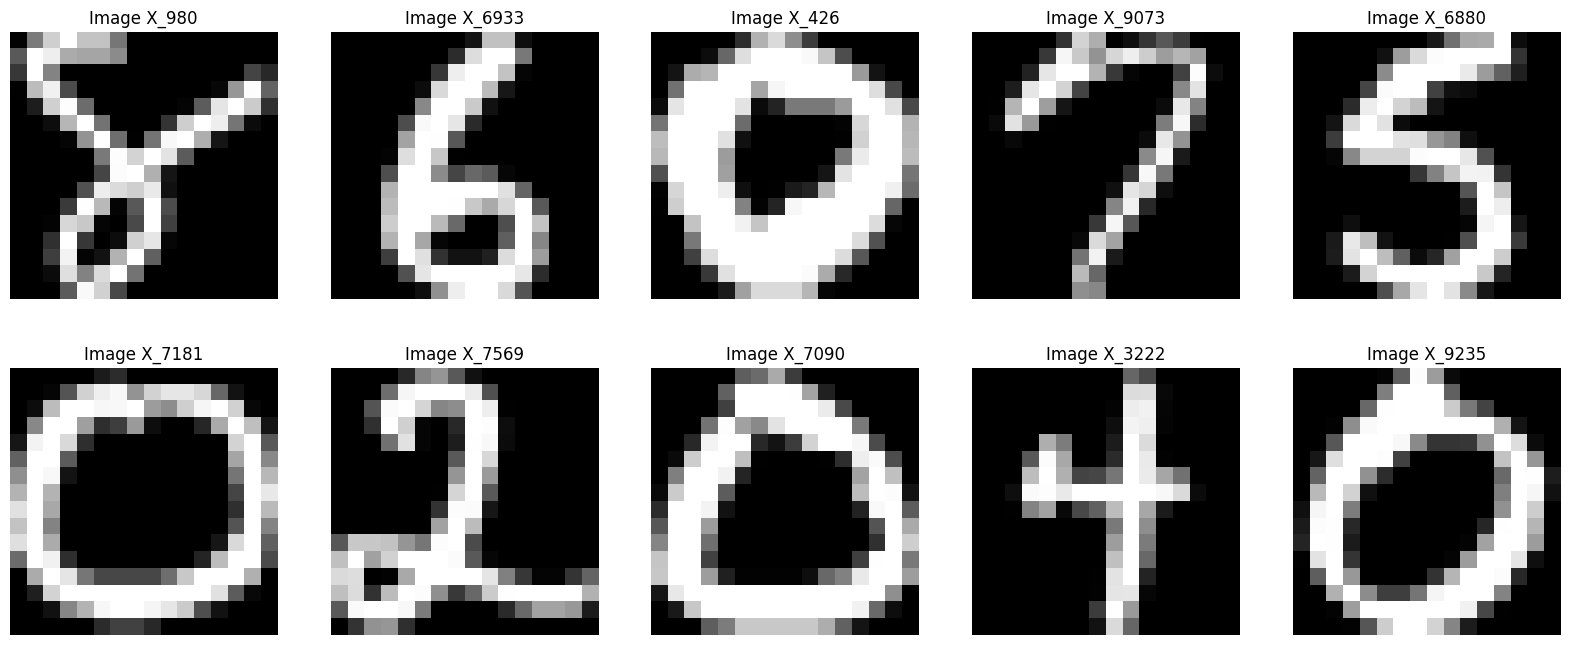

In [26]:
n_images = 10
random_indexes = np.random.choice(range(len(X)), n_images)
images = X[random_indexes]

plt.subplots(2, 5, figsize=(20, 8))
for i in range(n_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Image X_{random_indexes[i]}")
    plt.axis('off')
plt.show()

In [27]:
# params = {
#     "activation_functions": [Tanh],
#     "batch_size": [32],
#     "gradient_step": [0.001],
#     "loss": [MSELoss],
#     "n_epochs": [100],
#     "n_neurons_per_layer": [[X_train.shape[1], 128, 64, 32]],
# }

params = {
    "activation_functions": [Sigmoid, Tanh],
    "batch_size": [32, 64, 128],
    "gradient_step": [0.01, 0.001],
    "loss": [BCELoss, MSELoss],
    "n_epochs": [100, 250, 500],
    "n_neurons_per_layer": [[X_train.shape[1], 128, 64, 32], [X_train.shape[1], 100, 10], [X_train.shape[1], 128, 32]],
}

best_model, best_params, best_score, best_losses = grid_search(X_train, X_test, y_train, y_test, params)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


In [28]:
print("Best parameters: ", best_params)

Best parameters:  {'activation_functions': 'Sigmoid', 'batch_size': 32, 'gradient_step': 0.01, 'loss': 'BCELoss', 'n_epochs': 500, 'n_neurons_per_layer': [256, 128, 32]}


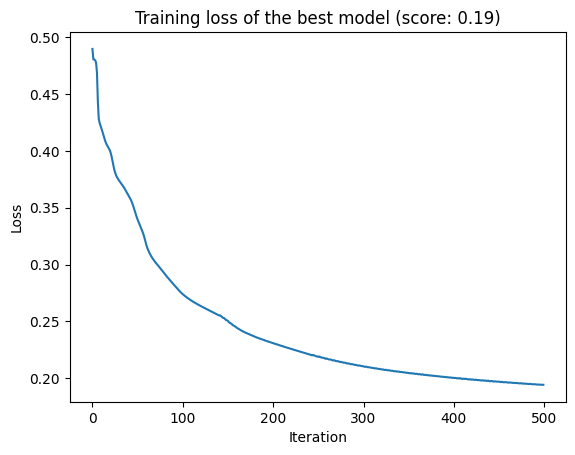

In [29]:
plt.plot(best_losses)
plt.title(f"Training loss of the best model (score: {best_score:.2f})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Again, the BCE loss seems great and converging.

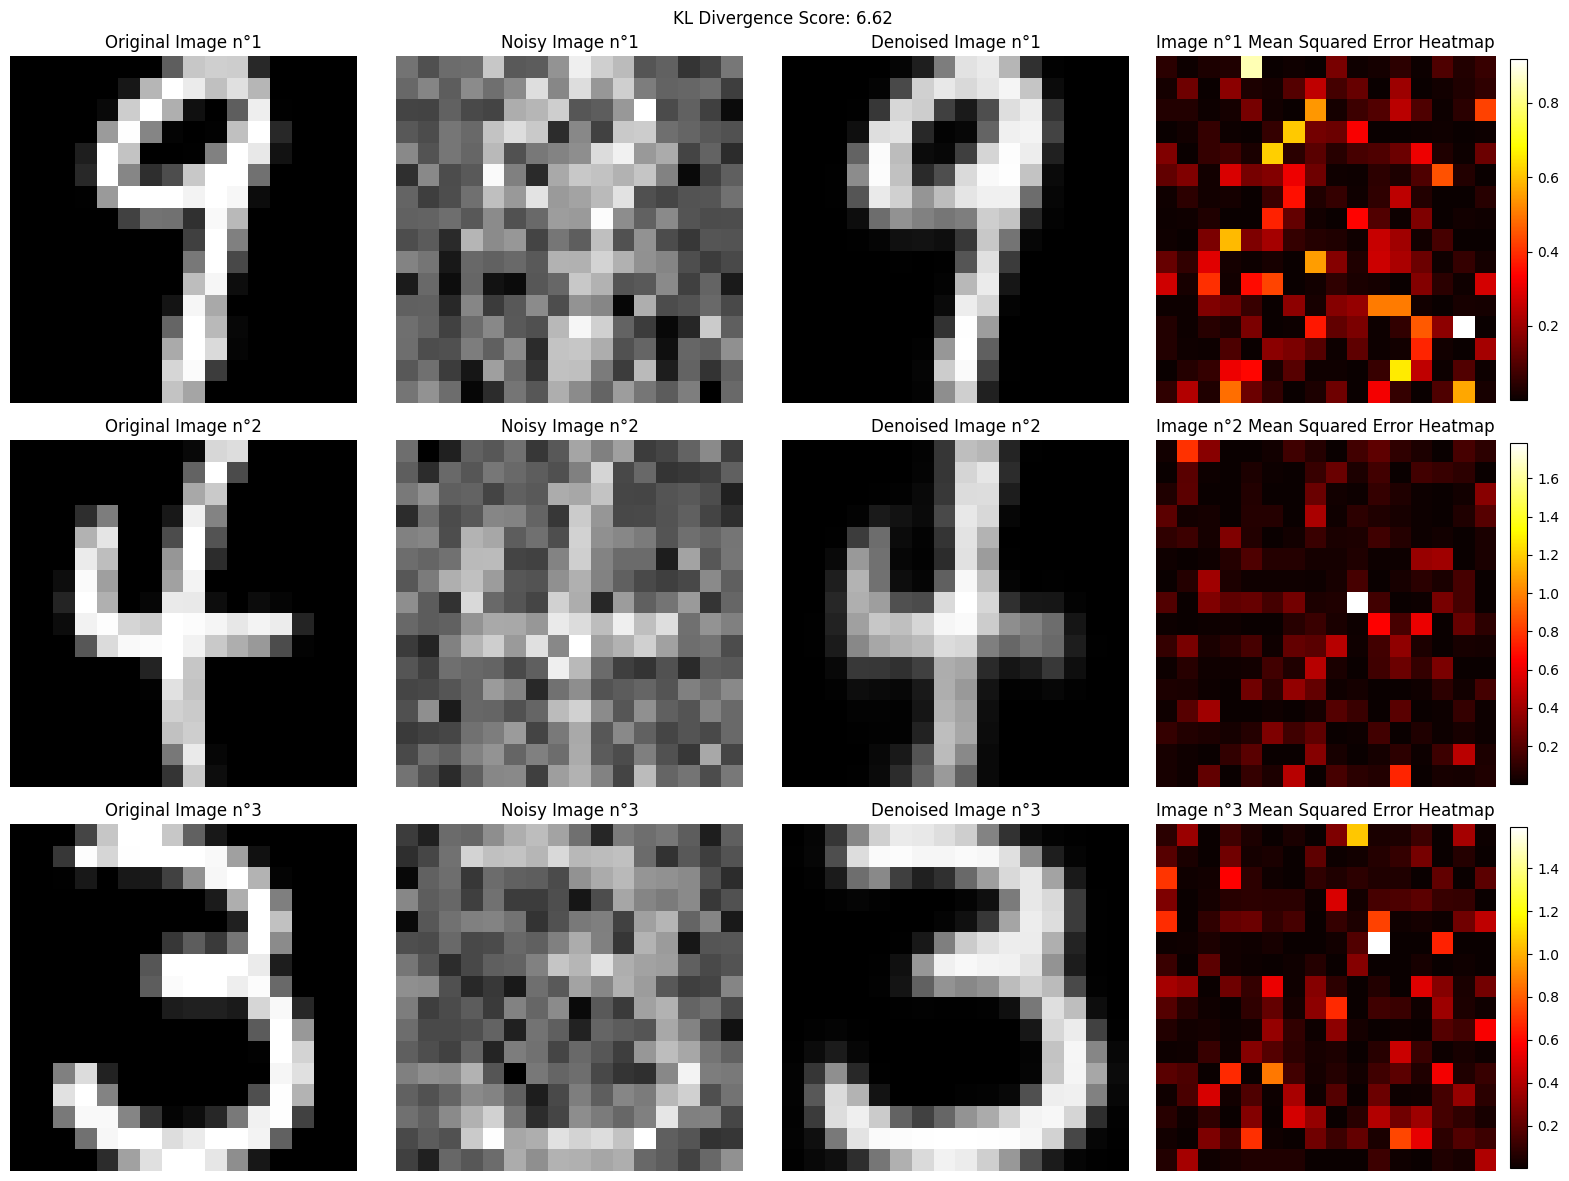

In [30]:
n_images = 3

random_indexes = np.random.choice(range(len(X_test)), n_images)
original_images = y_test[random_indexes]
noisy_images = X_test[random_indexes]
denoised_images = best_model(noisy_images)

plt.figure(figsize=(16, 4 * n_images))
plt.suptitle(f"KL Divergence Score: {kullback_leibler_divergence(original_images, denoised_images):.2f}")


for i in range(n_images):
    # Plot original image
    plt.subplot(n_images, 4, 4 * i + 1)
    plt.imshow(original_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Original Image n°{i+1}")
    plt.axis('off')

    # Plot noisy image
    plt.subplot(n_images, 4, 4 * i + 2)
    plt.imshow(noisy_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Noisy Image n°{i+1}")
    plt.axis('off')

    # Plot denoised image
    plt.subplot(n_images, 4, 4 * i + 3)
    plt.imshow(denoised_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"Denoised Image n°{i+1}")
    plt.axis('off')

    # Calculate and plot the heatmap
    mse_images = (noisy_images[i] - denoised_images[i])**2
    heatmap_data = mse_images.reshape(16, 16)
    plt.subplot(n_images, 4, 4 * (i + 1))
    heatmap = plt.imshow(heatmap_data, cmap='hot', aspect='auto')
    plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    plt.title(f'Image n°{i+1} Mean Squared Error Heatmap')
    plt.axis('off')

plt.tight_layout()
plt.show()


The reconstructed images look similar to the original ones. But there are still minor inconsistencies as the heatmaps show many, even though small, differences.

In [31]:
X, y = load_usps("../data/USPS_data.txt")

# Min-Max Scaling
x_min = X.min()
x_max = X.max()
X = (X - x_min) / (x_max - x_min)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train_one_hot = encode_one_hot(y_train)
y_test_one_hot = encode_one_hot(y_test)

network = Sequential(Linear(X_train.shape[1], 128), Sigmoid(), Linear(128, 64), Sigmoid(), Linear(64, y_train_one_hot.shape[1]))
loss = CrossEntropyLoss()

losses = SGD(network, loss, X_train, y_train_one_hot, batch_size=64, gradient_step=1e-3, n_iter=1000)

100%|██████████| 1000/1000 [01:50<00:00,  9.08it/s]


In [32]:
yhat = predict(X_test)
print(f"Accuracy: {accuracy(y_test, yhat)*100:.2f}%")

yhat_noise = predict(X_noise)
print(f"Accuracy using noised images: {accuracy(y, yhat_noise)*100:.2f}%")

yhat_denoise = predict(best_model(X_noise))
print(f"Accuracy using denoised images: {accuracy(y, yhat_denoise)*100:.2f}%")

Accuracy: 96.13%
Accuracy using noised images: 90.99%
Accuracy using denoised images: 96.06%


This time, the accuracy with the denoised images is very close to the accuracy computed with the original images. Also, the gap with the noisy images is more significant.

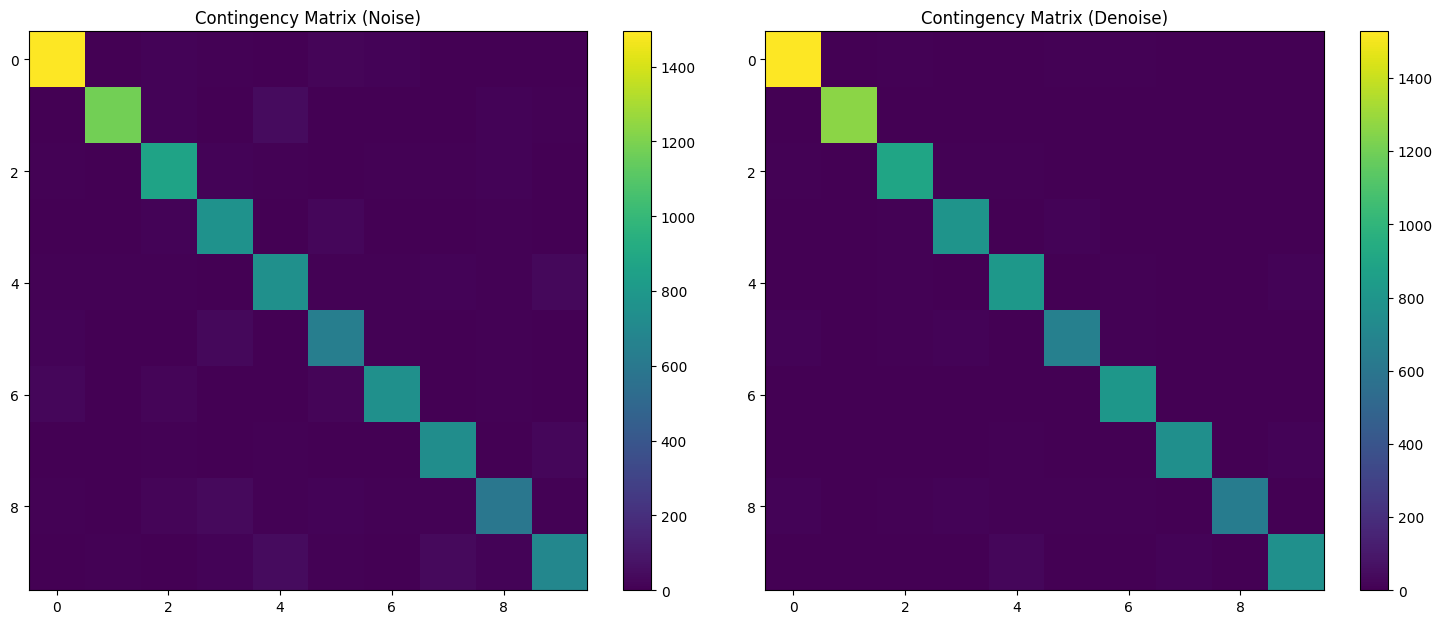

In [33]:
# Calculate contingency matrices
m_noise = contingency_matrix(y, yhat_noise)
m_denoise = contingency_matrix(y, yhat_denoise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting contingency matrix for yhat_noise
axs[0].imshow(m_noise)
axs[0].set_title("Contingency Matrix (Noise)")
plt.colorbar(axs[0].imshow(m_noise), ax=axs[0])

# Plotting contingency matrix for yhat_denoise
axs[1].imshow(m_denoise)
axs[1].set_title("Contingency Matrix (Denoise)")
plt.colorbar(axs[1].imshow(m_denoise), ax=axs[1])

plt.tight_layout()
plt.show()

Overall, the contingency matrix has much less inaccurate data compared to the previous dataset. It is also more visible that the denoised data yields better results.